# Objective: 

Experimentation is key to innovation at big tech companies. And to measure its success, there needs to be statistical rigor and not just lift in the test group.

After helping to build out v0 experimentation framework at Mercari, I wanted to dig deeper into A/B testing advancements when it comes to more rigorous and modern techniques. 

This notebook serves as a Python code application of this [Towards Data Science article](https://towardsdatascience.com/how-to-select-the-right-statistical-tests-for-different-a-b-metrics-c8a1865851e) about how experimentation was done at TikTok as well as answers to [interview questions](https://prepfully.com/interview-questions/stitch-fix/data-scientist?page=3) from Stitch Fix's Data Scientist team.

In [1]:
!pip install duckdb jupysql --quiet #dask-expr

In [2]:
# Data Maniupulation

# import dask
# dask.config.set({'dataframe.query-planning': True})
# import dask.dataframe as dd

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb 
# import dask
# dask.config.set({'dataframe.query-planning': True})
# import dask.dataframe as dd

import numpy as np
import pandas as pd

# Statistics
from scipy import stats
import scipy.stats

# Test for Normality
from scipy.stats import shapiro

# Statistical Test
from scipy.stats import mannwhitneyu

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

Deploy Shiny apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


# What is the Python code for calculating the confidence intervals for a mean?

In [3]:
#ChatGPT 3.5

# Generate some sample datanp.random.seed(42)  # For reproducibility
data = np.random.normal(loc=5, scale=2, size=100)  # Sample data with mean 5 and standard deviation 2

# Calculate mean and standard error of the mean (SEM)
mean = np.mean(data)
sem = stats.sem(data)

# Define confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate margin of error
margin_of_error = sem * stats.t.ppf((1 + confidence_level) / 2, len(data) - 1)

# Calculate confidence interval
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

print("Sample Mean:", mean)
print("Standard Error of the Mean (SEM):", sem)
print(f"Confidence Interval ({confidence_level * 100}%):", confidence_interval)


Sample Mean: 4.94107688262016
Standard Error of the Mean (SEM): 0.19419162724287448
Confidence Interval (95.0%): (4.555758564003793, 5.326395201236527)


In [4]:
#ChatGPT 4.0 Turbo:

# Let's assume you have some data in a Python list
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Calculate the mean and standard error
mean = np.mean(data)
standard_error = scipy.stats.sem(data)

# Define the confidence level to be 95%
confidence_level = 0.95

# Calculate the confidence interval
confidence_interval = scipy.stats.t.interval(confidence_level, len(data)-1, loc=mean, scale=standard_error)

print(f"The confidence interval is: {confidence_interval}")

The confidence interval is: (3.3341494103866087, 7.665850589613392)


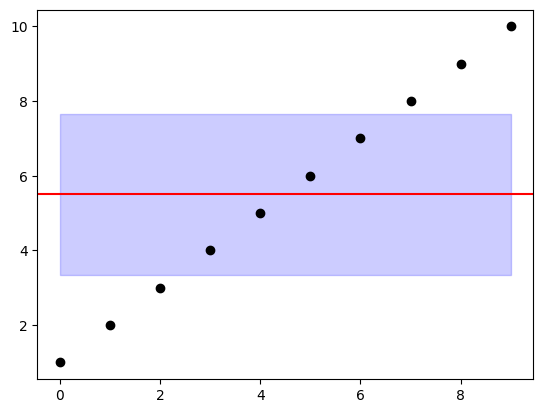

In [5]:
# Plot the CI intervals

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the mean as a red line
ax.axhline(mean, color='red')

# Plot the confidence interval as a blue band
ax.fill_between(range(len(data)), confidence_interval[0], confidence_interval[1], color='blue', alpha=0.2)

# Plot the data points
ax.plot(data, 'ko')

# Show the plot
plt.show()

In [6]:
# Trying to use whole dataframe without it crashing
# cust_behav = dd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv')

In [7]:
# Let us use some more realistic data from e-commerce store (which is what TikTok article referenced as well as similar to current Stitch Fix biz model - Freestyle)
# cust_behav = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv')
# cust_behav

In [8]:
# cust_behav['event_type'].value_counts(normalize=True)

In [9]:
# %%timeit

# cust_behav2 = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv')
# cust_behav2

In [10]:
# Will reduce the dataset to 80% and see if notebook crashes
# cb_sample = cust_behav.sample(frac=0.50)

In [11]:
# Saved sample set to make loading data faster
cb_sample = pd.read_csv('/kaggle/input/e-commerce-event-data/cb_sample.csv')
cb_sample

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,40314660,2019-10-30 07:37:25 UTC,view,13901154,2053013557343158789,construction.components.faucet,genebre,127.96,527374947,1c147519-8b26-4aa0-bc78-b593fb16ae87
1,2338187,2019-10-02 18:32:55 UTC,view,4801946,2053013554658804075,electronics.audio.headphone,apple,25.45,525642970,7e7b0311-0a76-4888-b915-6c2a240b67bb
2,5052611,2019-10-05 03:05:49 UTC,view,2300244,2053013560530830019,electronics.camera.video,sjcam,213.56,554631275,7c3b8b60-d7fa-4c9c-87b0-6b2f753d8807
3,3182699,2019-10-03 15:11:16 UTC,view,4802587,2053013554658804075,electronics.audio.headphone,ergo,6.41,519968351,1629fd4b-1669-48e7-876b-ac3a9676d8d8
4,27866997,2019-10-21 02:28:29 UTC,view,1003304,2053013555631882655,electronics.smartphone,apple,577.66,519451311,4aa7ae59-de22-4411-aadf-d69ef2b11e82
...,...,...,...,...,...,...,...,...,...,...
21224377,21315512,2019-10-16 13:13:16 UTC,view,12703516,2053013553559896355,NaN,continental,157.53,521388327,ed112838-018a-47fb-9f48-687e6c0b99d4
21224378,14281888,2019-10-11 20:24:27 UTC,view,1004250,2053013555631882655,electronics.smartphone,apple,814.64,514341869,d50e86d9-8871-4562-ae97-332069f43a06
21224379,906055,2019-10-01 15:59:23 UTC,view,22800104,2053013560463721151,NaN,weifeng,16.73,544992104,a95ef75f-055a-4943-91d9-d50ad09941ef
21224380,11580434,2019-10-10 02:12:26 UTC,view,1004834,2053013555631882655,electronics.smartphone,samsung,170.92,545294859,fd44937e-b3d3-4d15-b441-4410c564eda0


In [12]:
# Choosing to use dataset with even number of users. 
# Event-level data so massive dataset with 42 million rows. 
# Let us explore the data a bit more to see right now how much it can be used for interview q's as well as for practical app of article

query = """
select count(distinct user_id) as unique_users
from cb_sample
"""

duckdb.query(query).df()

,unique_users
0,2531962


In [13]:
query = """
select event_type
, count(*) as total
from cb_sample
group by 1
order by 2 desc
"""

duckdb.query(query).df() # Typical funnel (inverted triangle)

,event_type,total
0,view,20389114
1,cart,463911
2,purchase,371357


In [14]:
cb_sample['event_type'].value_counts(normalize=True) # Great. The proportion of events is same from sample to original dataset

event_type
view        0.960646
cart        0.021857
purchase    0.017497
Name: proportion, dtype: float64

In [15]:
# Need to create user table with experient group assignment. Then join this to event table

query = """
select distinct user_id
from cb_sample
"""

users = duckdb.query(query).df()
len(users)

2531962

In [16]:
# Number of users is uneven. so need to get rid of one user
query = """
select user_id
, count(*)
from cb_sample
group by 1
order by 2 asc
"""

duckdb.query(query).df()

,user_id,count_star()
0,520932432,1
1,539973712,1
2,515732150,1
3,549607746,1
4,561477882,1
...,...,...
2531957,512505687,1413
2531958,513021392,1458
2531959,526731152,1466
2531960,512365995,1975


In [17]:
# Creating even number of users.
# USER_ID MAY NEED TO BE MODIFIED DUE TO RANDOM SAMPLING 

# query = """
# select distinct user_id
# from cb_sample
# where user_id != 537261383
# """

# users = duckdb.query(query).df()
# len(users)

In [18]:
# Create list of even amont of ctl and test labels, randomize the labels and append to users table

half_length = len(users) // 2
experiment_group = ['control'] * half_length + ['test'] * half_length
np.random.shuffle(experiment_group)
users['experiment_group'] = experiment_group

In [19]:
query = """
select experiment_group
, count(*) as count
from users
group by 1
"""

duckdb.query(query).df()

,experiment_group,count
0,test,1265981
1,control,1265981


In [20]:
# join users table to event table
query = """
select *
from users u
join cb_sample scb
on u.user_id = scb.user_id
"""

df = duckdb.query(query).df()
len(df) == len(cb_sample)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

True

In [21]:
query = """
select experiment_group
, user_id
, sum(case when event_type='view' then 1 else 0 end) as total_views
, sum(case when event_type='cart'then 1 else 0 end) as total_cart
, sum(case when event_type='purchase'then 1 else 0 end) as total_purchase
from df
group by 1,2
"""

events_agg = duckdb.query(query).df()
events_agg

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,experiment_group,user_id,total_views,total_cart,total_purchase
0,control,515036954,390.0,1.0,1.0
1,control,544629459,15.0,0.0,0.0
2,control,559167266,10.0,0.0,0.0
3,control,558373696,32.0,0.0,0.0
4,test,512782815,8.0,0.0,0.0
...,...,...,...,...,...
2531957,test,565018368,1.0,0.0,0.0
2531958,test,548558681,1.0,0.0,0.0
2531959,test,563224845,1.0,0.0,0.0
2531960,test,519350557,1.0,0.0,0.0


In [22]:
# Split between experiment groups
query = """
select *
from events_agg
where experiment_group = 'control'
"""

ctl_events_agg = duckdb.query(query).df()

query = """
select *
from events_agg
where experiment_group = 'test'
"""

test_events_agg = duckdb.query(query).df()

### Checking Distributions for Control and Experiment Groups

In [23]:
def is_normal(data):
    stat, p = shapiro(data)
    alpha = 0.05
    if p > alpha:
        return 'Sample looks Gaussian (fail to reject H0)'
    else:
        return 'Sample does not look Gaussian (reject H0)'

In [24]:
# only get events columns
event_cols = ctl_events_agg[['total_views', 'total_cart', 'total_purchase']]
event_cols

,total_views,total_cart,total_purchase
0,390.0,1.0,1.0
1,15.0,0.0,0.0
2,10.0,0.0,0.0
3,32.0,0.0,0.0
4,16.0,0.0,0.0
...,...,...,...
1265976,1.0,0.0,0.0
1265977,1.0,0.0,0.0
1265978,1.0,0.0,0.0
1265979,1.0,0.0,0.0


In [25]:
for i in range(0,len(list(event_cols))):
    
    col = list(event_cols)[i]
    
    print('Control', col, 'Distribution:', is_normal(ctl_events_agg[col]))

    print('Test', col, 'Distribution:',is_normal(test_events_agg[col]))

/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Control total_views Distribution: Sample does not look Gaussian (reject H0)
Test total_views Distribution: Sample does not look Gaussian (reject H0)
Control total_cart Distribution: Sample does not look Gaussian (reject H0)
Test total_cart Distribution: Sample does not look Gaussian (reject H0)
Control total_purchase Distribution: Sample does not look Gaussian (reject H0)
Test total_purchase Distribution: Sample does not look Gaussian (reject H0)


None of the distributions are normal. So cannot use the t-test for statistical significance.

### First Quick Pass of CI on One Experiment Test Group's Behavior Metric

The confidence interval is: (8.018272440205267, 8.077736899587352)


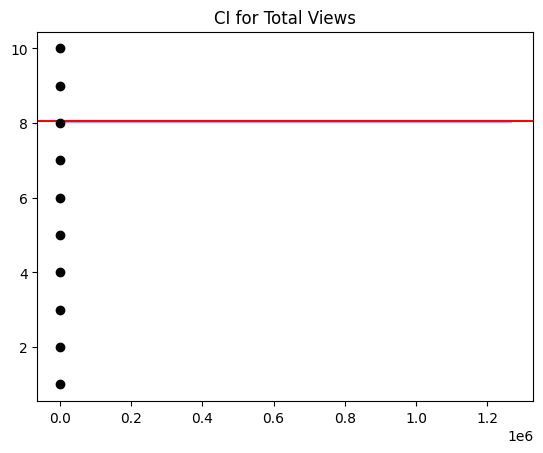

In [26]:
# Create confidence interval with the new data (Ctl group's views)

# Let's assume you have some data in a Python list
ctl_user_views = ctl_events_agg['total_views']

# Calculate the mean and standard error
mean = np.mean(ctl_user_views)
standard_error = scipy.stats.sem(ctl_user_views)

# Define the confidence level to be 95%
confidence_level = 0.95

# Calculate the confidence interval
confidence_interval = scipy.stats.t.interval(confidence_level, len(ctl_user_views)-1, loc=mean, scale=standard_error)

print(f"The confidence interval is: {confidence_interval}")

# Plot the CI intervals

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the mean as a red line
ax.axhline(mean, color='red')

# Plot the confidence interval as a blue band
ax.fill_between(range(len(ctl_user_views)), confidence_interval[0], confidence_interval[1], color='blue', alpha=0.2)

# Plot the data points
ax.plot(data, 'ko')

# Show the plot
plt.title("CI for Total Views")
plt.show()

# Statistical Testing Methods

## User Average Metrics
### Distributions are non-normal --> Use Mann Whitney U Test

In [27]:
# Now let us aggregate data at randomization unit to build CI interval
# Simulating real biz A/B test data

# Calculate avg views/carts/purchase per user for each experiment group
query = """
select experiment_group
, event_time[:10] as date
, sum(case when event_type = 'view' then 1 else 0 end)/count(distinct user_id) as views_per_user
, sum(case when event_type = 'cart' then 1 else 0 end)/count(distinct user_id) as carts_per_user
, sum(case when event_type = 'purchase' then 1 else 0 end)/count(distinct user_id) as purchases_per_user
from df
group by 1,2
"""

user_avg_metric = duckdb.query(query).df()
user_avg_metric

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,experiment_group,date,views_per_user,carts_per_user,purchases_per_user
0,control,2019-10-21,3.750218,0.100116,0.069805
1,control,2019-10-08,3.775728,0.051808,0.064511
2,test,2019-10-02,3.919181,0.057720,0.065190
3,test,2019-10-06,4.034788,0.104402,0.070898
4,test,2019-10-30,3.821188,0.055735,0.068989
...,...,...,...,...,...
57,control,2019-10-05,4.022459,0.111952,0.072039
58,test,2019-10-24,3.793476,0.109322,0.073205
59,test,2019-10-22,3.814761,0.104273,0.072893
60,control,2019-10-30,3.824639,0.054274,0.068311


In [28]:
control = duckdb.query("select * from user_avg_metric where experiment_group = 'control'").df()
test = duckdb.query("select * from user_avg_metric where experiment_group = 'test'").df()

In [29]:
# Metrics are skewed so using Mann Whitney U test to determine statistical significance

def run_mann_whitney_u_test(df1, df2, col):
    # Extract the two data samples
    data1 = df1[col]
    data2 = df2[col]

    # Perform the Mann-Whitney U test
    stat, p = mannwhitneyu(data1, data2)

    alpha = 0.05
    if p<alpha:
        print("We can reject Ho in favor of Ha. Therefore there is statistical significant difference between experiment groups in favor of treatment group.")
    else:
        print("We do not have enough evidence to reject Ho. Therefore, there is no significant statistical difference between two experiment groups' metric of interest.")

columns = list(user_avg_metric)[2:]
for c in columns:
    print('Metric:', c)
    run_mann_whitney_u_test(control, test, c)

Metric: views_per_user
We do not have enough evidence to reject Ho. Therefore, there is no significant statistical difference between two experiment groups' metric of interest.
Metric: carts_per_user
We do not have enough evidence to reject Ho. Therefore, there is no significant statistical difference between two experiment groups' metric of interest.
Metric: purchases_per_user
We do not have enough evidence to reject Ho. Therefore, there is no significant statistical difference between two experiment groups' metric of interest.


## User-level Conversion Metrics

In [30]:
# User events aggregated
events_agg

,experiment_group,user_id,total_views,total_cart,total_purchase
0,control,515036954,390.0,1.0,1.0
1,control,544629459,15.0,0.0,0.0
2,control,559167266,10.0,0.0,0.0
3,control,558373696,32.0,0.0,0.0
4,test,512782815,8.0,0.0,0.0
...,...,...,...,...,...
2531957,test,565018368,1.0,0.0,0.0
2531958,test,548558681,1.0,0.0,0.0
2531959,test,563224845,1.0,0.0,0.0
2531960,test,519350557,1.0,0.0,0.0


In [31]:
# Need to make a new column to change user as either making a purchase (at least one) -> 1 or not -> 0.
user_conversion = duckdb.query("select *, case when total_purchase >1 then 1 else 0 end as conversion from events_agg").df()
user_conversion.head()

,experiment_group,user_id,total_views,total_cart,total_purchase,conversion
0,control,515036954,390.0,1.0,1.0,0
1,control,544629459,15.0,0.0,0.0,0
2,control,559167266,10.0,0.0,0.0,0
3,control,558373696,32.0,0.0,0.0,0
4,test,512782815,8.0,0.0,0.0,0
